## Hysterese
Dieses Beispiel demonstriert die Analyse von Daten,
die mit einem USB-Oszilloskop der Marke `PicoScope` am
Versuch zur Hysterese aufgenommen wurden. Die aufgezeichneten Werte 
für Strom und B-Feld werden in einen Zweig für steigenden und 
fallenden Strom aufgeteilt, mit Hilfe von kubischen Splines 
interpoliert und dann integriert. 


In [1]:
# -*- coding: utf-8 -*-
"""Beispiel_Hysterese.py 
   Auswertung der Daten aus einer mit PicoScope erstellten Datei
   im txt-Format am Beispiel des Hystereseversuchs

   * Einlesen der Daten aus PicoScope-Datei vom Typ .txt oder .csv

   * Kalibration der Achsen

   * Darstellung Kanal_a vs. Kanal_b

   * Auftrennung in zwei Zweige für steigenden bzw. abnehmenden Strom

   * Interpolation durch kubische Splines

   * Integration der Spline-Funktionen

.. moduleauthor:: Guenter Quast <g.quast@kit.edu>

   last modified:
   30-Dec-22 GQ used meanFilter() for smoothing;
                inserted option to calibrate axes, improved graphics 

"""

# -----example Code illustrating usage --------------------
import numpy as np, matplotlib.pyplot as plt
from PhyPraKit import readPicoScope, resample, meanFilter
from scipy import signal
from scipy import interpolate
import sys

# check for / read command line arguments
if len(sys.argv) == 2:
    fname = sys.argv[1]
else:
    fname = "Hysterese.csv"
print(("\n*==* script " + sys.argv[0] + " executing \n", "     processing file " + fname))

# read data from PicoScope
units, data = readPicoScope(fname, delim=",")
ic = len(data)
print("  --> %i columns recieved" % ic)
print("      units", units, end=" ")
t = data[0]
l = len(t)
print(("  sample length ", l, "\n"))

#! this depends on cabling of the PicoScope !
vU_I = data[2]  # proportional to Current
vU_B = data[1]  # proportional to B-Field

#! if length is too large, resample by appropriate factor
if l > 400:
    nr = int(l / 150)
    print(("** smoothing with window size ", nr))
    vU_I = meanFilter(vU_I, width=nr)
    vU_B = meanFilter(vU_B, width=nr)
    print(("** resampling by factor ", nr))
    vU_I, t = resample(vU_I, t, n=nr)
    vU_B = resample(vU_B, n=nr)

#! put code to calibrate axes in terms of H and B here
fU_I2H = 200.0  # U_R -> H <-- adjust !
fU_B2B = 1.3  # U_C -> B <-- adjust !
vH = vU_I * fU_I2H
vB = vU_B * fU_B2B
unitH = "(A/m)"
unitB = "(T)"

print("** spline interpolation")
cs_H = interpolate.UnivariateSpline(t, vH, s=0)
cs_B = interpolate.UnivariateSpline(t, vB, s=0)
tplt = np.linspace(t[0], t[-1], 150)

('\n*==* script /usr/lib/python3.6/site-packages/ipykernel_launcher.py executing \n', '     processing file Hysterese.csv')
  --> 3 columns recieved
      units ['(ms)', '(V)', '(V)'] ('  sample length ', 7816, '\n')
('** smoothing with window size ', 52)
('** resampling by factor ', 52)
** spline interpolation


## Grafische Darstellung der Eingabedaten

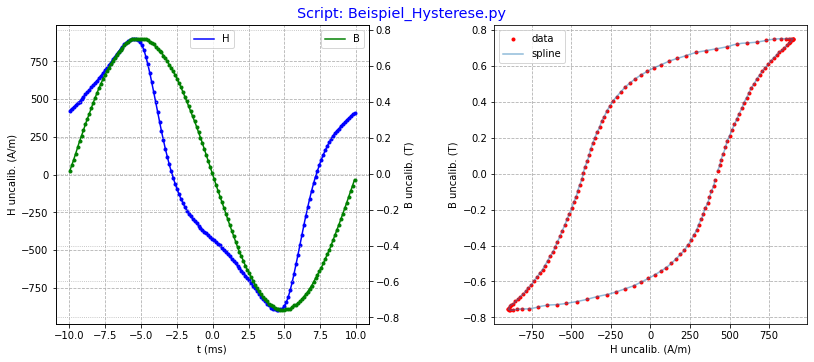

In [2]:
# plot calibrated input data
fig = plt.figure(1, figsize=(12.0, 5.0))
fig.suptitle("Script: Beispiel_Hysterese.py", size="x-large", color="b")
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.97, top=0.93, wspace=0.4, hspace=0.3)  # plot raw data ...
ax1 = fig.add_subplot(1, 2, 1)
#  ax1.set_ylim(np.min(a)*1.05, np.max(a)*1.7)
ax1.plot(t, vH, "b.")
ax1.plot(tplt, cs_H(tplt), "b-", label="H")
ax1b = ax1.twinx()
ax1b.plot(t, vB, "g.")
ax1b.plot(tplt, cs_B(tplt), "g-", label="B")
ax1.set_xlabel("t " + units[0])
ax1.set_ylabel("H uncalib. " + unitH)
ax1b.set_ylabel("B uncalib. " + unitB)
ax1.legend(numpoints=1, loc="upper center")
ax1b.legend(numpoints=1, loc="upper right")
ax1.grid(linestyle="dashed")
ax1b.grid(linestyle="dotted")
# ... and interpolated data a vs. b
ax2 = fig.add_subplot(1, 2, 2)
tplt = np.linspace(t[0], t[-1], 200)
ax2.plot(vH, vB, "r.", label="data")
ax2.plot(cs_H(tplt), cs_B(tplt), "-", alpha=0.5, label="spline")
ax2.set_xlabel("H uncalib. " + unitH)
ax2.set_ylabel("B uncalib. " + unitB)
ax2.legend(numpoints=1, loc="best")
ax2.grid(linestyle="dashed")

plt.show()

## Auftrennen nach steigendem und fallendem Strom zur Berechnung des Umlaufintegrals

In [6]:
# take derivative of channel a
#  -- this is used to determine the branch of the hysteresis curve
cs_Hderiv = cs_H.derivative()
# for increasing current
Hp = []
Bp = []
# for decreasing current
Hm = []
Bm = []
#  tlist = np.linspace(t[0], t[-1], 200) #
for i, ti in enumerate(t):
    if cs_Hderiv(ti) > 0.0:
        Hp.append(vH[i])
        Bp.append(vB[i])
    else:
        Hm.append(vH[i])
        Bm.append(vB[i])

# convert to (simultaneously) sorted arrays ...
idxp = np.argsort(Hp)
Hp = np.array(Hp)[idxp]
Bp = np.array(Bp)[idxp]
idxm = np.argsort(Hm)
Hm = np.array(Hm)[idxm]
Bm = np.array(Bm)[idxm]

# ... and provide smooth spline approximation
#   !!! adjusting s is magic here, should correspond to the "precision"
prec = (max(Hp) - min(Hp)) * 10e-7
cs_Bp = interpolate.UnivariateSpline(Hp, Bp, s=prec)
cs_Bm = interpolate.UnivariateSpline(Hm, Bm, s=prec)

# finally, calculate integral between curves (i.e. the energy per cycle and unit volume)
Hmin = max(np.min(Hp), np.min(Hm))
Hmax = min(np.max(Hp), np.max(Hm))
integral = cs_Bm.integral(Hmin, Hmax) - cs_Bp.integral(Hmin, Hmax)

## Grafische Darstellung getrennt nach steigendem und fallendem Strom und des Umlaufintegrals

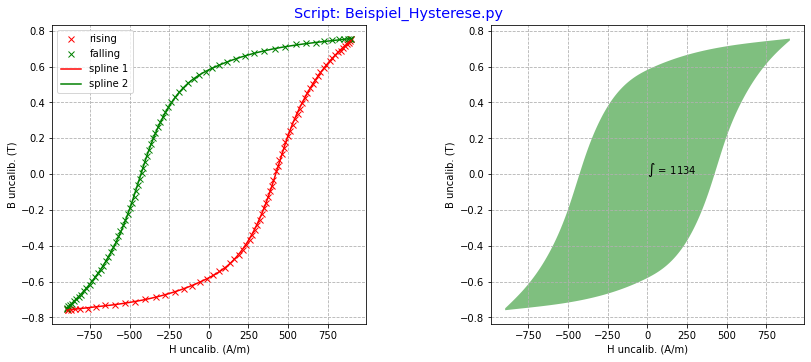

In [7]:
# create Figure
fig = plt.figure(2, figsize=(12.0, 5.0))
fig.suptitle("Script: Beispiel_Hysterese.py", size="x-large", color="b")
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.97, top=0.93, wspace=0.4, hspace=0.3)  # plot raw data ...

# plot separate branches for riding and falling current
ax3 = fig.add_subplot(1, 2, 1)
ax3.plot(Hp, Bp, "rx", label="rising")
ax3.plot(Hm, Bm, "gx", label="falling")
Hplt = np.linspace(Hmin, Hmax, 200)
ax3.plot(Hplt, cs_Bp(Hplt), "r-", label="spline 1")
ax3.plot(Hplt, cs_Bm(Hplt), "g-", label="spline 2")
ax3.legend(numpoints=1, loc="best")
ax3.set_xlabel("H uncalib. " + unitH)
ax3.set_ylabel("B uncalib. " + unitB)
ax3.grid(linestyle="dashed")
# plot interpolated functions and integral
ax4 = fig.add_subplot(1, 2, 2)
# form a singele contour to plot
ax4.fill(
    np.concatenate((Hplt, np.flipud(Hplt))),
    np.concatenate((cs_Bp(Hplt), np.flipud(cs_Bm(Hplt)))),
    "g",
    alpha=0.5,
)
# ax4.fill(Hplt, cs_bB(Hplt), 'g', alpha=0.5)
# ax4.fill(Hplt, cs_Bm(Hplt), 'g', alpha=0.5)
ax4.text(-1.0, 0.0, "$\int\,=\,$%.4g" % integral)
ax4.set_xlabel("H uncalib. " + unitH)
ax4.set_ylabel("B uncalib. " + unitB)
ax4.grid(linestyle="dashed")

plt.show()